<a href="https://colab.research.google.com/github/DhruvGoyal2001/BlackBeard_Task/blob/main/Blackbeard_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -r -N -c -np https://physionet.org/files/sleep-edfx/1.0.0/

In [4]:
import os
!pwd

/content


In [ ]:
!pip install -U mne

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
import glob
file_name = '/content/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette'
psg_fnames = glob.glob(os.path.join(file_name, "*PSG.edf"))
ann_fnames = glob.glob(os.path.join(file_name, "*Hypnogram.edf"))
psg_fnames.sort()
ann_fnames.sort()
psg_fnames = np.asarray(psg_fnames)
ann_fnames = np.asarray(ann_fnames)

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_train = []
annot_train = []

for k in range(len(psg_fnames)):
  raw_train.append(mne.io.read_raw_edf(psg_fnames[k]))
  annot_train.append(mne.read_annotations(ann_fnames[k]))

  #raw_train.set_annotations(annot_train, emit_warning=False)
  #raw_train.set_channel_types(mapping)

  # plot some data
  #raw_train.plot(duration=60, scalings='auto')

In [17]:
print(annot_train[10])
print(raw_train[10])

<Annotations | 130 segments: Sleep stage 1 (19), Sleep stage 2 (45), Sleep ...>
<RawEDF | SC4051E0-PSG.edf, 7 x 8166000 (81660.0 s), ~12 kB, data not loaded>


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


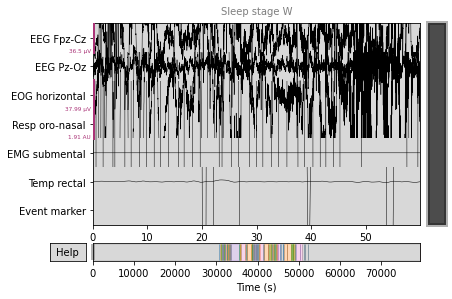

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


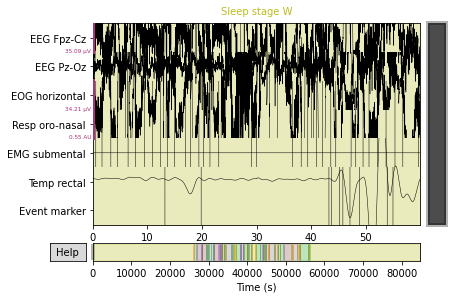

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


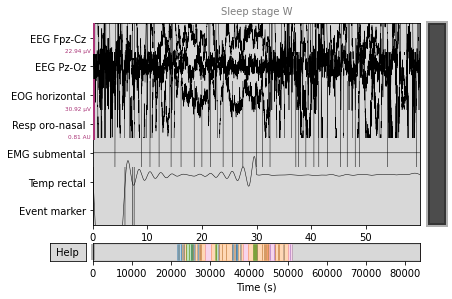

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


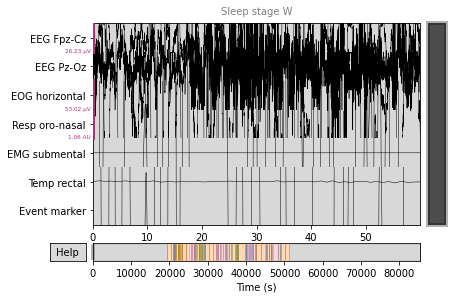

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


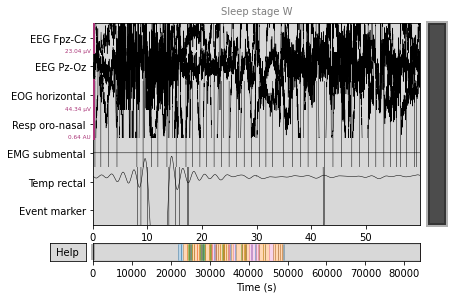

In [13]:
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}
           
for k in range(5):
  raw_train[k].set_annotations(annot_train[k], emit_warning=False)
  raw_train[k].set_channel_types(mapping)

  # plot some data
  raw_train[k].plot(duration=60, scalings='auto')

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


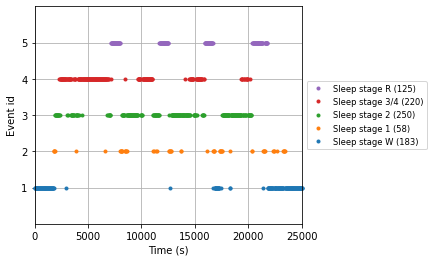

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


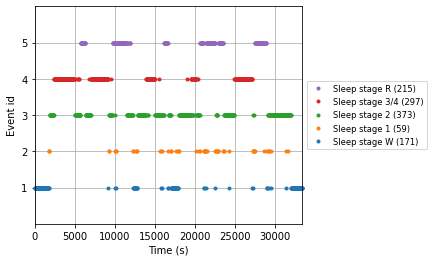

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


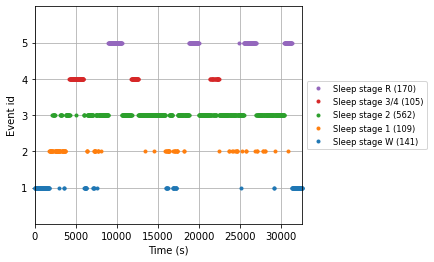

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


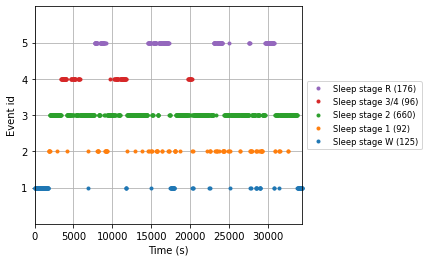

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


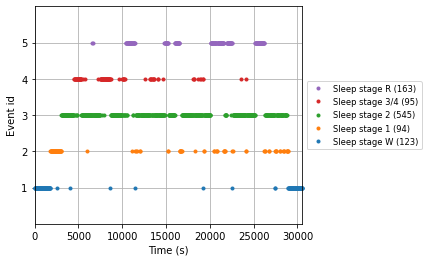

In [24]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
for k in range(5):
  annot_train[k].crop(annot_train[k][1]['onset'] - 30 * 60,
                 annot_train[k][-2]['onset'] + 30 * 60)
  raw_train[k].set_annotations(annot_train[k], emit_warning=False)

  events_train, _ = mne.events_from_annotations(
      raw_train[k], event_id=annotation_desc_2_event_id, chunk_duration=30.)

  # create a new event_id that unifies stages 3 and 4
  event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

  # plot events
  fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train[k].info['sfreq'],
                          first_samp=events_train[0, 0])

  # keep the color-code for further plotting
  stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [26]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
for k in range(5):
  annot_train[k].crop(annot_train[k][1]['onset'] - 30 * 60,
                 annot_train[k][-2]['onset'] + 30 * 60)
  raw_train[k].set_annotations(annot_train[k], emit_warning=False)

  events_train, _ = mne.events_from_annotations(
      raw_train[k], event_id=annotation_desc_2_event_id, chunk_duration=30.)

  tmax = 30. - 1. / raw_train[k].info['sfreq']  # tmax in included

  epochs_train = mne.Epochs(raw=raw_train[k], events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

  print(epochs_train)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
836 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  836 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125
 'Sleep stage W': 183>
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1115 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1115 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 59
 'Sleep stage 2': 373
 'Sleep stage 3/4': 297
 'Sleep stage R': 215
 'Sleep stage W': 171>
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sle

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
836 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1009 matching events found
No baseline correction applied
0 projection items activated
Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS w

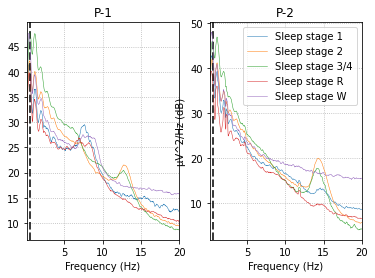

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1115 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
952 matching events found
No baseline correction applied
0 projection items activated
Loading data for 59 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 373 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS w

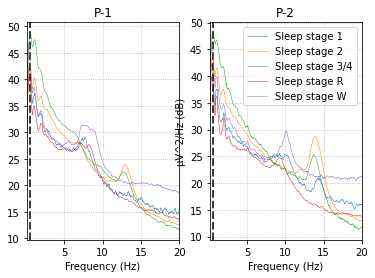

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1087 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
911 matching events found
No baseline correction applied
0 projection items activated
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS 

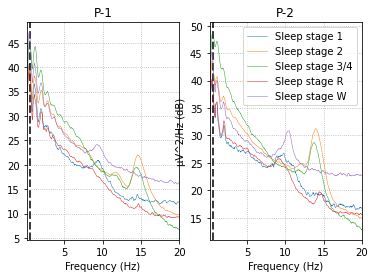

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1149 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1235 matching events found
No baseline correction applied
0 projection items activated
Loading data for 92 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 660 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading d

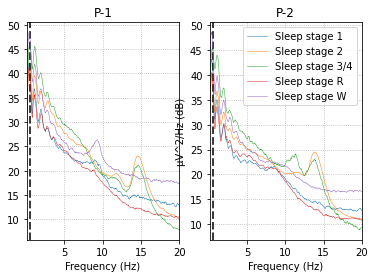

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1200 matching events found
No baseline correction applied
0 projection items activated
Loading data for 94 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 545 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS 

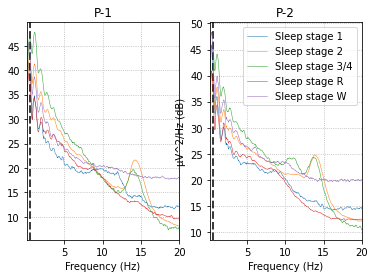

In [29]:
for k in range(5):
  annot_train[k].crop(annot_train[k][1]['onset'] - 30 * 60,
                 annot_train[k][-2]['onset'] + 30 * 60)
  raw_train[k].set_annotations(annot_train[k], emit_warning=False)

  events_train, _ = mne.events_from_annotations(
      raw_train[k], event_id=annotation_desc_2_event_id, chunk_duration=30.)

  tmax = 30. - 1. / raw_train[k].info['sfreq']  # tmax in included

  epochs_train = mne.Epochs(raw=raw_train[k], events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)
  
  raw_test = mne.io.read_raw_edf(psg_fnames[k+5])
  annot_test = mne.read_annotations(ann_fnames[k+5])
  annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
  raw_test.set_annotations(annot_test, emit_warning=False)
  raw_test.set_channel_types(mapping)
  events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
  epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)
  #PSD by sleep stage.
  fig, (ax1, ax2) = plt.subplots(ncols=2)

  # iterate over the subjects
  stages = sorted(event_id.keys())
  for ax, title, epochs in zip([ax1, ax2],
                             ['P-1', 'P-2'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
  ax2.set(ylabel='µV^2/Hz (dB)')
  ax2.legend(ax2.lines[2::3], stages)
  plt.show()

In [31]:
from matplotlib import pyplot as plt
from mne.datasets import sample
from mne.time_frequency import csd_fourier, csd_multitaper, csd_morlet

In [32]:
n_jobs = 4

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
836 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 836 events and 121 original time points ...
0 bad epochs dropped
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/209 [00:00<?,       ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(

[done]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(

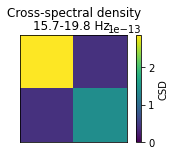

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1115 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1115 events and 121 original time points ...
0 bad epochs dropped
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/279 [00:00<?,       ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend

[done]


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_job

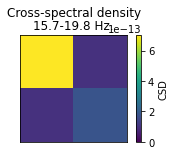

In [41]:
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

for k in range(2):
  annot_train[k].crop(annot_train[k][1]['onset'] - 30 * 60,
                 annot_train[k][-2]['onset'] + 30 * 60)
  raw_train[k].set_annotations(annot_train[k], emit_warning=False)

  events_train, _ = mne.events_from_annotations(
      raw_train[k], event_id=annotation_desc_2_event_id, chunk_duration=30.)

  tmax = 30. - 1. / raw_train[k].info['sfreq']  # tmax in included

  picks = mne.pick_types(raw_train[k].info, meg='grad')

  epochs = mne.Epochs(raw = raw_train[k], events = events_train, event_id=event_id, tmin=-0.2, tmax=1,
                    baseline=(None, 0), preload=True)
  csd_fft = csd_fourier(epochs, fmin=15, fmax=20, n_jobs=4)
  csd_fft.mean().plot()